In [1]:
symbol = input("Enter the symbol : ")

Enter the symbol : TCS


In [2]:

signalsdict = {'Open':True,
               'NewOpen_1':True,
               'NewOpen_2':True,
               'NewOpen_3':True,
               'Close': True,
               'NewClose_1':True,
               'NewClose_2':True,
               'NewClose_3':True,
               'NewHigh_1':True,
               'NewHigh_2':True,
               'NewHigh_3':True,
               'NewLow_1':True,
               'NewLow_2':True,
               'NewLow_3':True,
               "fast_ema":True,
               "slow_ema":True,
               "macd":False,
               "signal":False}
signals = [s for s in signalsdict.keys() if signalsdict[s]]
signals

['Open',
 'NewOpen_1',
 'NewOpen_2',
 'NewOpen_3',
 'Close',
 'NewClose_1',
 'NewClose_2',
 'NewClose_3',
 'NewHigh_1',
 'NewHigh_2',
 'NewHigh_3',
 'NewLow_1',
 'NewLow_2',
 'NewLow_3',
 'fast_ema',
 'slow_ema']

In [3]:
from nse import *
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta
import json
import urllib
import pandas as pd
import concurrent
from concurrent.futures import ALL_COMPLETED


In [4]:
def calculate_macd(data, fast_period=12, slow_period=26, signal_period=9):
    """
    Calculate the MACD for a column in a pandas DataFrame using a sliding window approach.

    :param data: pandas DataFrame containing the data
    :param fast_period: number of periods for the fast EMA
    :param slow_period: number of periods for the slow EMA
    :param signal_period: number of periods for the signal line
    :return: pandas DataFrame with the MACD and signal line added as columns
    """
    # Calculate the fast and slow EMAs
    data['fast_ema'] = data['Close'].ewm(span=fast_period, adjust=False).mean()
    data['slow_ema'] = data['Close'].ewm(span=slow_period, adjust=False).mean()

    # Calculate the MACD and signal line
    data['macd'] = data['fast_ema'] - data['slow_ema']
    data['signal'] = data['macd'].ewm(span=signal_period, adjust=False).mean()

    return data

In [5]:
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [6]:
today = datetime.now()
oneyearago = today - timedelta(days=365)

date_format = "%d-%m-%Y"

df = scrape_data(f"{oneyearago.strftime(date_format)}",f"{today.strftime(date_format)}",symbol)
rawdata = df.copy()
df.head()

,Date,Symbol,Series,High Price,Low Price,Open Price,Close Price,Last Price,Prev Close Price,Total Traded Quantity,Total Traded Value,52 Week High Price,52 Week Low Price
0,2022-06-20,TCS,EQ,3138.75,3069.00,3094.00,3112.40,3134.95,3088.90,1502769,4.670409e+09,4043.0,3023.85
1,2022-06-21,TCS,EQ,3237.75,3125.40,3130.00,3211.95,3215.00,3112.40,2964461,9.486098e+09,4043.0,3023.85
2,2022-06-22,TCS,EQ,3250.55,3183.00,3199.90,3222.95,3225.30,3211.95,3336315,1.074487e+10,4043.0,3023.85
3,2022-06-23,TCS,EQ,3318.00,3222.95,3222.95,3308.80,3312.95,3222.95,3692578,1.210647e+10,4043.0,3023.85
4,2022-06-24,TCS,EQ,3345.00,3277.50,3339.00,3293.10,3295.05,3308.80,2132118,7.038904e+09,4043.0,3023.85


In [7]:
df = df[['Date','High Price', 'Low Price', 'Open Price','Close Price']]
df.columns = ['Date','High', 'Low', 'Open','Close']
df.head()

,Date,High,Low,Open,Close
0,2022-06-20,3138.75,3069.00,3094.00,3112.40
1,2022-06-21,3237.75,3125.40,3130.00,3211.95
2,2022-06-22,3250.55,3183.00,3199.90,3222.95
3,2022-06-23,3318.00,3222.95,3222.95,3308.80
4,2022-06-24,3345.00,3277.50,3339.00,3293.10


In [8]:
def make_data(df,name,n,col):
    for i in range(1,n+1):
        df[f"{name}_{i}"] = df[col].shift(+i)
    return df

make_data(df,"NewOpen",3,"Open")
make_data(df,"NewClose",3,"Close")
make_data(df,"NewHigh",3,"High")
make_data(df,"NewLow",3,"Low")
calculate_macd(df, 12, 26, 9)
df.head()

,Date,High,Low,Open,Close,NewOpen_1,NewOpen_2,NewOpen_3,NewClose_1,NewClose_2,...,NewHigh_1,NewHigh_2,NewHigh_3,NewLow_1,NewLow_2,NewLow_3,fast_ema,slow_ema,macd,signal
0,2022-06-20,3138.75,3069.00,3094.00,3112.40,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3112.400000,3112.400000,0.000000,0.000000
1,2022-06-21,3237.75,3125.40,3130.00,3211.95,3094.00,NaN,NaN,3112.40,NaN,...,3138.75,NaN,NaN,3069.00,NaN,NaN,3127.715385,3119.774074,7.941311,1.588262
2,2022-06-22,3250.55,3183.00,3199.90,3222.95,3130.00,3094.0,NaN,3211.95,3112.40,...,3237.75,3138.75,NaN,3125.40,3069.0,NaN,3142.366864,3127.416735,14.950129,4.260635
3,2022-06-23,3318.00,3222.95,3222.95,3308.80,3199.90,3130.0,3094.0,3222.95,3211.95,...,3250.55,3237.75,3138.75,3183.00,3125.4,3069.0,3167.971962,3140.852533,27.119429,8.832394
4,2022-06-24,3345.00,3277.50,3339.00,3293.10,3222.95,3199.9,3130.0,3308.80,3222.95,...,3318.00,3250.55,3237.75,3222.95,3183.0,3125.4,3187.222429,3152.130123,35.092306,14.084377


In [9]:
df = df.dropna()
df.head()

,Date,High,Low,Open,Close,NewOpen_1,NewOpen_2,NewOpen_3,NewClose_1,NewClose_2,...,NewHigh_1,NewHigh_2,NewHigh_3,NewLow_1,NewLow_2,NewLow_3,fast_ema,slow_ema,macd,signal
3,2022-06-23,3318.0,3222.95,3222.95,3308.80,3199.90,3130.00,3094.00,3222.95,3211.95,...,3250.55,3237.75,3138.75,3183.00,3125.40,3069.00,3167.971962,3140.852533,27.119429,8.832394
4,2022-06-24,3345.0,3277.50,3339.00,3293.10,3222.95,3199.90,3130.00,3308.80,3222.95,...,3318.00,3250.55,3237.75,3222.95,3183.00,3125.40,3187.222429,3152.130123,35.092306,14.084377
5,2022-06-27,3362.9,3306.50,3350.00,3314.70,3339.00,3222.95,3199.90,3293.10,3308.80,...,3345.00,3318.00,3250.55,3277.50,3222.95,3183.00,3206.834363,3164.172336,42.662027,19.799907
6,2022-06-28,3330.0,3272.60,3307.00,3318.15,3350.00,3339.00,3222.95,3314.70,3293.10,...,3362.90,3345.00,3318.00,3306.50,3277.50,3222.95,3223.959846,3175.578089,48.381757,25.516277
7,2022-06-29,3333.0,3271.00,3271.00,3290.50,3307.00,3350.00,3339.00,3318.15,3314.70,...,3330.00,3362.90,3345.00,3272.60,3306.50,3277.50,3234.196793,3184.090823,50.105970,30.434215


In [10]:
import numpy as np

def join_data(df, l):
    final_x = []
    for i in l:
        final_x.append(np.array(df[i]).reshape(-1,1))
        
    return np.concatenate(final_x,axis=1)

final_x = join_data(df, signals)
final_x = pd.DataFrame(final_x, columns=signals)
# y = np.array(df["Close"]).reshape(-1,1)

In [11]:
drop = -30
train = final_x[:drop].sample(frac=1)
test = final_x[drop:]

X_train,y_train= train.drop("Close", axis=1),train["Close"] 
X_test, y_test = test.drop("Close", axis=1),test["Close"].reset_index().drop('index',axis=1)

In [12]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=2000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.005)

In [13]:
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:3240.43550	validation_1-rmse:3248.00988
[100]	validation_0-rmse:1970.25917	validation_1-rmse:1976.30456
[200]	validation_0-rmse:1200.28209	validation_1-rmse:1193.68649
[300]	validation_0-rmse:732.43497	validation_1-rmse:722.09690
[400]	validation_0-rmse:448.01879	validation_1-rmse:438.97561
[500]	validation_0-rmse:275.05208	validation_1-rmse:267.24792
[600]	validation_0-rmse:170.11294	validation_1-rmse:162.82154
[700]	validation_0-rmse:106.79685	validation_1-rmse:99.96489
[800]	validation_0-rmse:69.18906	validation_1-rmse:63.07369
[900]	validation_0-rmse:47.47367	validation_1-rmse:42.80540
[1000]	validation_0-rmse:35.29549	validation_1-rmse:33.64572
[1100]	validation_0-rmse:28.76717	validation_1-rmse:30.60473
[1200]	validation_0-rmse:25.25806	validation_1-rmse:30.25573
[1230]	validation_0-rmse:24.57299	validation_1-rmse:30.34214


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

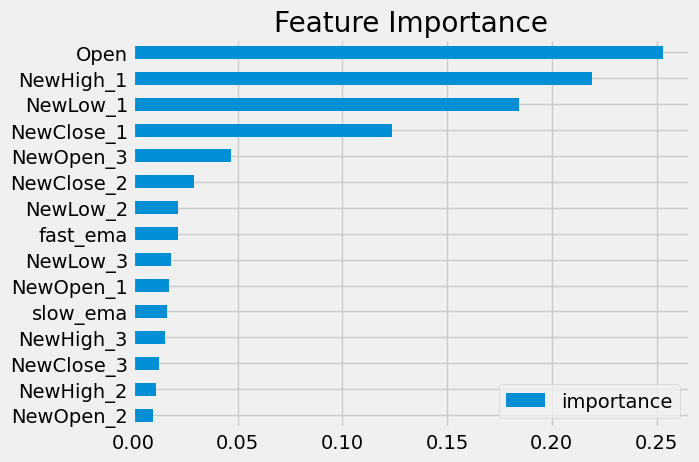

In [14]:
fi = pd.DataFrame(data=reg.feature_importances_,
             columns=['importance'],index=[param for param in signals if param != "Close" ])
fi.sort_values('importance').plot.barh(title='Feature Importance')

plt.show()

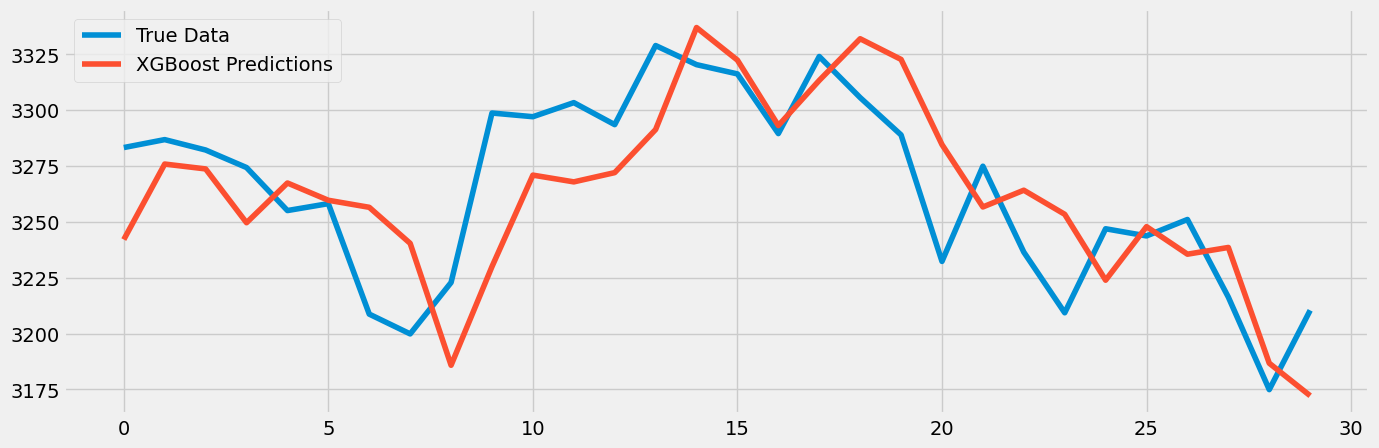

In [15]:
xgpred = reg.predict(X_test)
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(y_test,label='True Data')
plt.plot(xgpred,label='XGBoost Predictions')
plt.legend(loc="upper left")
plt.show()

In [16]:
from sklearn.linear_model import LinearRegression
lin_model=LinearRegression()

In [17]:
lin_model.fit(X_train,y_train)

LinearRegression()

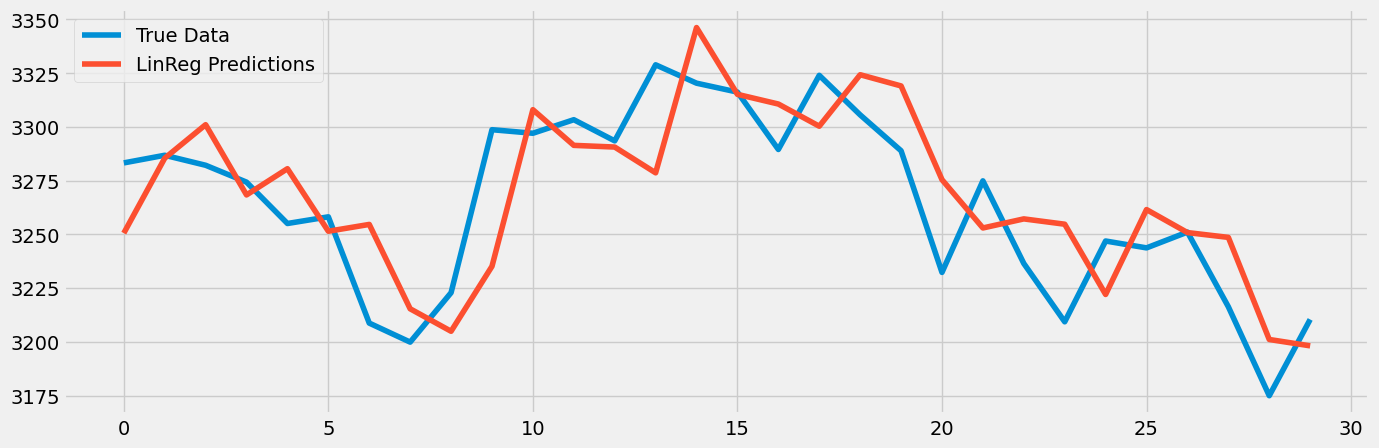

In [18]:
lin_pred=lin_model.predict(X_test)
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(y_test,label='True Data')
plt.plot(lin_pred,label='LinReg Predictions')
plt.legend(loc="upper left")
plt.show()

In [19]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(n_estimators=1000,max_features=10, random_state=1,verbose=True)

In [20]:
model.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


RandomForestRegressor(max_features=10, n_estimators=1000, random_state=1,
                      verbose=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


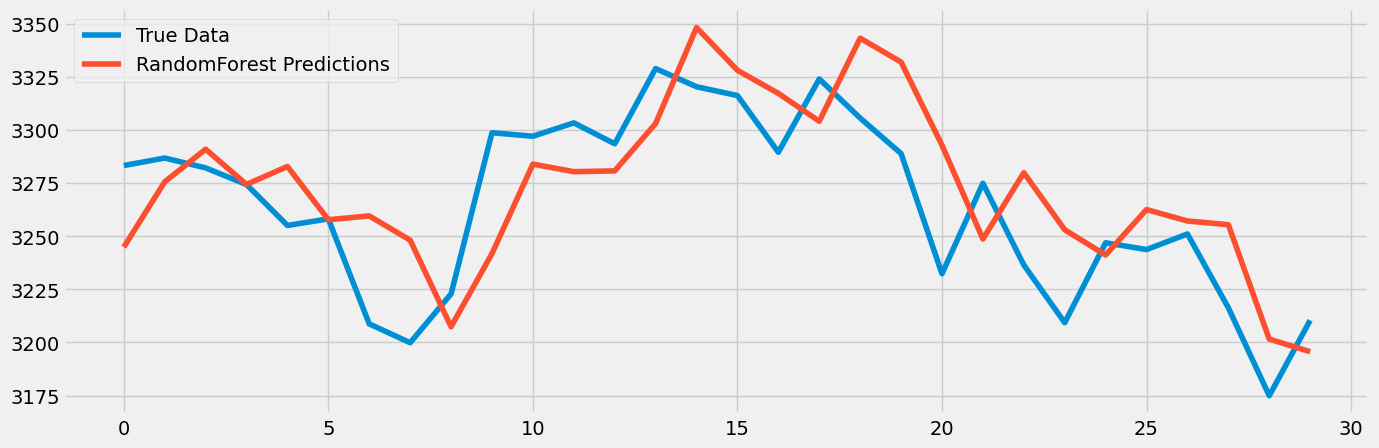

In [21]:
pred=model.predict(X_test)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(y_test,label='True Data')
plt.plot(pred,label='RandomForest Predictions')
plt.legend(loc="upper left")
plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


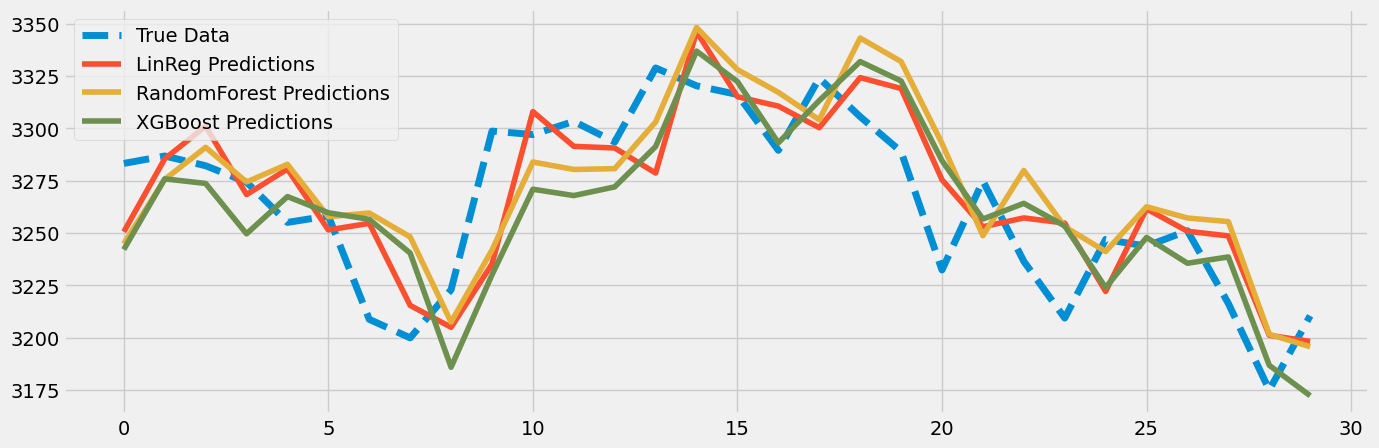

In [22]:
lin_pred=lin_model.predict(X_test)
pred=model.predict(X_test)
xgpred = reg.predict(X_test)
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(y_test,label='True Data',linestyle='--',linewidth=5)
plt.plot(lin_pred,label='LinReg Predictions')
plt.plot(pred,label='RandomForest Predictions')
plt.plot(xgpred,label='XGBoost Predictions')
plt.legend(loc="upper left")
plt.show()


In [23]:
df.tail()

,Date,High,Low,Open,Close,NewOpen_1,NewOpen_2,NewOpen_3,NewClose_1,NewClose_2,...,NewHigh_1,NewHigh_2,NewHigh_3,NewLow_1,NewLow_2,NewLow_3,fast_ema,slow_ema,macd,signal
243,2023-06-13,3265.00,3239.00,3260.0,3243.70,3215.0,3245.0,3261.0,3246.90,3209.30,...,3254.40,3250.00,3270.00,3211.00,3205.35,3233.00,3259.771310,3259.914305,-0.142994,9.539195
244,2023-06-14,3255.85,3225.85,3243.7,3251.05,3260.0,3215.0,3245.0,3243.70,3246.90,...,3265.00,3254.40,3250.00,3239.00,3211.00,3205.35,3258.429570,3259.257689,-0.828119,7.465732
245,2023-06-15,3247.45,3210.00,3245.3,3216.30,3243.7,3260.0,3215.0,3251.05,3243.70,...,3255.85,3265.00,3254.40,3225.85,3239.00,3211.00,3251.948098,3256.075638,-4.127540,5.147078
246,2023-06-16,3199.40,3156.00,3197.0,3174.90,3245.3,3243.7,3260.0,3216.30,3251.05,...,3247.45,3255.85,3265.00,3210.00,3225.85,3239.00,3240.094544,3250.062628,-9.968084,2.124046
247,2023-06-19,3214.90,3175.00,3190.0,3210.40,3197.0,3245.3,3243.7,3174.90,3216.30,...,3199.40,3247.45,3255.85,3156.00,3210.00,3225.85,3235.526153,3247.124656,-11.598503,-0.620464


In [24]:
yesterday = df.tail(1)
today = pd.DataFrame(yesterday[signals])

def neg_make_data(df,name,n):
    for i in range(n-1,0,-1):
        df[f"{name}_{i+1}"] = df[f"{name}_{i}"]
    return df

neg_make_data(today,"NewOpen",3)
neg_make_data(today,"NewHigh",3)
neg_make_data(today,"NewLow",3)
today["NewOpen_1"] = today["Open"]
today = today.drop("Close", axis=1)
today["Open"] = float(input("Enter the today's Open "))
today

Enter the today's Open 3190


,Open,NewOpen_1,NewOpen_2,NewOpen_3,NewClose_1,NewClose_2,NewClose_3,NewHigh_1,NewHigh_2,NewHigh_3,NewLow_1,NewLow_2,NewLow_3,fast_ema,slow_ema
247,3190.0,3190.0,3197.0,3245.3,3174.9,3216.3,3251.05,3199.4,3199.4,3247.45,3156.0,3156.0,3210.0,3235.526153,3247.124656


In [25]:
reg.predict(today),lin_model.predict(today),model.predict(today)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


(array([3174.1147], dtype=float32), array([3209.4910884]), array([3191.81805]))

<Axes: >

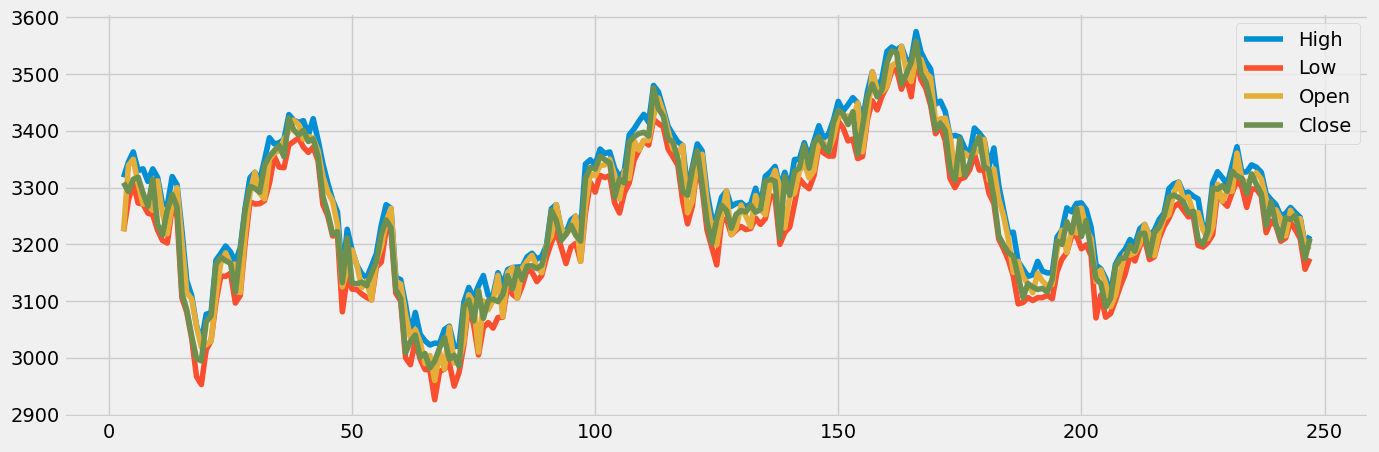

In [26]:
df[['High', 'Low', 'Open', 'Close']].plot()
# df.columns